### Ticker Technical Analysis 
Uses ticker pricing data for given date range and analyzes the buy and sell signals. 

In [117]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [118]:
# get tomorrows date so we can use this in the yf.download as an end date

date = datetime.now() + timedelta(days=1)
fmt_date = date.strftime('%Y-%m-%d')
fmt_date

'2024-10-12'

In [119]:
# enter ticker symbol and date range to retrieve

ticker = 'googl'
start_date = '2023-01-01'
end_date =  fmt_date

In [120]:
# Fetch data for a ticker via yahoo api 

df_intra = yf.download(ticker, start_date, end_date, interval='60m', progress=False)
df = yf.download(ticker, start_date, end_date, progress=False)

In [121]:
# EMA - Calculates the Daily EMA, Intra-Day EMA & stores it to respective dataframes

def calculate_ema(fast_ema, slow_ema, data_set):
    fema = data_set['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = data_set['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

# call calculate_ema and pass in the ema values and data sets
df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)
df_intra['EMA_A'], df_intra['EMA_B'] = calculate_ema(5, 7, df_intra)


In [122]:
# RSI - Calulates the RSI and adds median_rsi and RSI to respective dataframes

def calculate_rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    dataset['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

    dataset['rsi'] = rsi

    return rs, rsi, median_rsi


my_rsi_values = calculate_rsi(df, 10, 90)
my_irsi_values = calculate_rsi(df_intra, 10, 90)

In [123]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Date,,,,,,,,,,
2024-10-09,163.449997,164.839996,159.740005,161.860001,161.860001,31181800,163.794686,163.970949,below_median,43.039723
2024-10-10,160.869995,163.070007,160.399994,162.080002,162.080002,14076700,163.223125,163.498212,below_median,44.147943


In [124]:
df_intra.head(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Datetime,,,,,,,,,,
2023-01-03 09:30:00,89.584999,91.050003,88.610001,88.989998,88.989998,8213969,88.989998,88.989998,below_median,NaN
2023-01-03 10:30:00,88.970001,89.580002,88.709999,89.169998,89.169998,2946041,89.049998,89.034998,above_median,100.000000
2023-01-03 11:30:00,89.180000,89.180000,88.580002,88.708504,88.708504,2352269,88.936167,88.953374,below_median,25.263417
2023-01-03 12:30:00,88.720001,88.980003,88.519997,88.879997,88.879997,1759223,88.917443,88.935030,below_median,43.400739
2023-01-03 13:30:00,88.875000,89.370003,88.849998,89.279999,89.279999,1762414,89.038295,89.021272,above_median,65.762431


In [125]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    return macd, macd_signal

df['MACD'], df['MACD_Signal'] = calculate_macd(df)
df_intra['MACD'], df_intra['MACD_Signal'] = calculate_macd(df_intra)

In [126]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,MACD_Signal
Date,,,,,,,,,,,,
2023-01-03,89.589996,91.050003,88.519997,89.120003,88.899872,28131200,89.120003,89.120003,below_median,NaN,0.000000,0.000000
2023-01-04,90.349998,90.650002,87.269997,88.080002,87.862442,34854800,88.773336,88.860003,below_median,0.000000,-0.082963,-0.016593
2023-01-05,87.470001,87.570000,85.900002,86.199997,85.987076,27194400,87.915556,88.195001,below_median,0.000000,-0.296989,-0.072672
2023-01-06,86.790001,87.690002,84.860001,87.339996,87.124260,41381500,87.723703,87.981250,below_median,32.108198,-0.370349,-0.132207
2023-01-09,88.360001,90.050003,87.860001,88.019997,87.802582,29003900,87.822467,87.990937,below_median,44.396004,-0.369358,-0.179637


In [127]:
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
EMA_A          0
EMA_B          0
Median_RSI     0
rsi            1
MACD           0
MACD_Signal    0
dtype: int64

In [128]:
df.dropna(inplace=True)
df_intra.dropna(inplace=True)

In [129]:
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
EMA_A          0
EMA_B          0
Median_RSI     0
rsi            0
MACD           0
MACD_Signal    0
dtype: int64

In [135]:
# KNN MODEL
def create_features(df):
    # df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B']) & (df['rsi'] < 30) & (df['MACD'] > df['Signal'])).astype(int)
    # df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B']) & (df['rsi'] > 70) & (df['MACD'] < df['Signal'])).astype(int)
    df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B']) & (df['MACD'] > df['MACD_Signal'])).astype(int)
    df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B']) & (df['MACD'] < df['MACD_Signal'])).astype(int)
    # df['Buy_Signal'] = ((df['EMA_A'] > df['EMA_B'])).astype(int)
    # df['Sell_Signal'] = ((df['EMA_A'] < df['EMA_B'])).astype(int)
    df['Signal'] = df['Buy_Signal'] - df['Sell_Signal']  # Buy: 1, Sell: -1, Hold: 0
    return df

df_knn = create_features(df)

# features (X) and labels (y)
features = ['EMA_A', 'EMA_B', 'rsi', 'MACD', 'MACD_Signal']  # You can add more indicators if needed
X = df_knn[features]
y = df_knn['Signal']

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn.fit(X_train_scaled, y_train)

# Step 6: Make predictions
y_pred = knn.predict(X_test_scaled)

# # Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Step 8: Display predicted buy/sell signals
df_test = df.iloc[len(X_train):].copy()
df_test['Predicted_Signal'] = y_pred

print("\nPredicted Buy/Sell Signals:")
df_test[['Close', 'EMA_A', 'EMA_B', 'rsi', 'MACD', 'Signal', 'Predicted_Signal']]


Accuracy: 59.55%

Predicted Buy/Sell Signals:


,Close,EMA_A,EMA_B,rsi,MACD,Signal,Predicted_Signal
Date,,,,,,,
2024-06-05,175.410004,174.242428,174.202753,59.964063,2.923761,0,1
2024-06-06,176.729996,175.071617,174.834564,64.953975,2.937037,0,1
2024-06-07,174.460007,174.867747,174.740925,52.075209,2.732886,0,-1
2024-06-10,175.009995,174.915163,174.808192,54.592170,2.585669,0,-1
2024-06-11,176.619995,175.483440,175.261143,61.433591,2.569294,0,1
...,...,...,...,...,...,...,...
2024-10-04,167.059998,165.939563,165.370396,71.601800,1.366643,1,1
2024-10-07,162.979996,164.953041,164.772796,47.382742,1.181903,1,-1
2024-10-08,164.380005,164.762029,164.674598,53.597108,1.135377,1,0


In [137]:
df_test.tail()

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,MACD_Signal,Buy_Signal,Sell_Signal,Signal,Predicted_Signal
Date,,,,,,,,,,,,,,,,
2024-10-04,168.059998,168.229996,165.479996,167.059998,167.059998,19047400,165.939563,165.370396,above_median,71.601800,1.366643,0.322257,1,0,1,1
2024-10-07,167.720001,168.479996,162.750000,162.979996,162.979996,22463100,164.953041,164.772796,below_median,47.382742,1.181903,0.494187,1,0,1,-1
2024-10-08,163.940002,164.729996,162.869995,164.380005,164.380005,23072700,164.762029,164.674598,above_median,53.597108,1.135377,0.622425,1,0,1,0
2024-10-09,163.449997,164.839996,159.740005,161.860001,161.860001,31181800,163.794686,163.970949,below_median,43.039723,0.884959,0.674932,0,0,0,-1
2024-10-10,160.869995,163.070007,160.399994,162.080002,162.080002,14076700,163.223125,163.498212,below_median,44.147943,0.696229,0.679191,0,0,0,-1


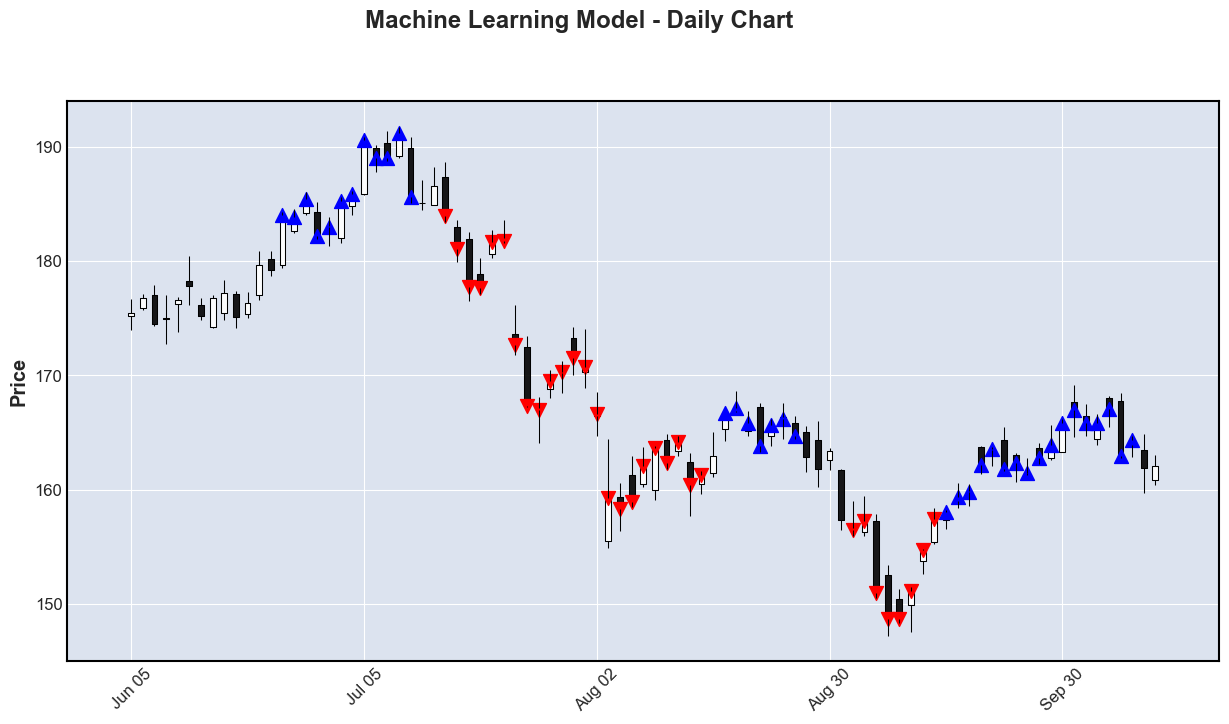

In [132]:

# Create the Signal column
df_test['Signal'] = np.where(df_test['Signal'] == 1, 1, np.where(df_test['Signal'] == -1, -1, np.nan))

# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    df_test,
    type='candle',
    title='Machine Learning Model - Daily Chart',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_test) + 1,
    addplot=[
        # Additional plot for buy signals
        mpf.make_addplot(
            np.where(df_test['Signal'] == 1, df_test['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for buy signal
            markersize=100,  # Marker size
            color='blue'     # Color for buy signals
        ),
        # Additional plot for sell signals
        mpf.make_addplot(
            np.where(df_test['Signal'] == -1, df_test['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for sell signal
            markersize=100,  # Marker size
            color='red'   # Color for sell signals
        )
    ]
)